In [1]:
from PIL import Image
from vangogh.evolution import Evolution
from vangogh.fitness import draw_voronoi_image
from vangogh.util import IMAGE_SHRINK_SCALE, REFERENCE_IMAGE
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use('classic')
%matplotlib inline

from multiprocess import Pool, cpu_count

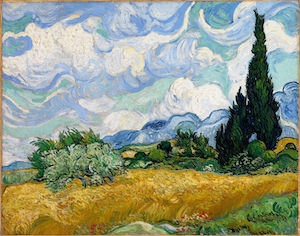

In [2]:
display(REFERENCE_IMAGE)

In [3]:
# Enable to show live rendering of best individual during optimization
display_output = False
# Enable to save progress images at every 50th generation
save_progress = True
# Enable to print verbose output per generation
verbose_output = True

In [4]:
def reporter(time, evo):
    if save_progress or display_output:
        elite = draw_voronoi_image(evo.elite, evo.reference_image.width, evo.reference_image.height, scale=IMAGE_SHRINK_SCALE)
    if display_output:
        clear_output()
        display(elite)
    if save_progress and time["num-generations"] % 50 == 0:
        elite.save(f"./img/van_gogh_intermediate_{evo.seed}_{evo.population_size}_{evo.crossover_method}_{evo.num_points}_{evo.initialization}_{evo.generation_budget}_{time['num-generations']:05d}.png")

def run_algorithm(settings):
    seed, population_size, crossover_method, num_points, initialization, generation_budget = settings
    start = time()
    
    data = []
    evo = Evolution(num_points,
                    REFERENCE_IMAGE,
                    population_size=population_size,
                    generation_reporter=reporter,
                    crossover_method=crossover_method,
                    seed=seed,
                    initialization=initialization,
                    generation_budget=generation_budget,
                    num_features_mutation_strength=.25,
                    selection_name='optimization',
                    verbose=verbose_output)
    data = evo.run()
    time_spent = time() - start
    print(f"Done: run {seed} - pop {population_size} - crossover {crossover_method} - num. points {num_points} - initialization {initialization} - in {int(time_spent)} seconds")
    
    return data

## Running a single instance

In [5]:
%%time
data = run_algorithm((0, 100, "UNIFORM", 100, 'RANDOM', 500))

Best current method: stochastic_universal_sampling, Diversity=3.884703480311239, Quality=0.6558561708615345, Combined Criterion=3.884703480311239
generation: 1 best fitness: 133079 avg. fitness: 143759.4
Best current method: linear_rank_selection, Diversity=3.8022498830633347, Quality=0.6484076222232191, Combined Criterion=2.225328752643277
generation: 2 best fitness: 127027 avg. fitness: 139841.41
Best current method: stochastic_universal_sampling, Diversity=3.7121242223599507, Quality=0.6640584499337312, Combined Criterion=1.6800803740758044
generation: 3 best fitness: 127027 avg. fitness: 137131.38
Best current method: linear_rank_selection, Diversity=3.5510853123343704, Quality=0.6673490510179938, Combined Criterion=1.388283116347088
generation: 4 best fitness: 127027 avg. fitness: 134774.45
Best current method: stochastic_universal_sampling, Diversity=3.437174159371962, Quality=0.6675006591163518, Combined Criterion=1.221435359167474
generation: 5 best fitness: 126006 avg. fitness

## Running a sweep of settings

In [6]:
%%time

generation_budget = 500

data = []
for seed in range(3):
    for population_size in (100,):
        for crossover_method in ("UNIFORM",):
            for initialization in ("RANDOM",):
                for num_points in (100,):
                    data.extend(run_algorithm((seed, population_size, crossover_method, num_points, initialization, generation_budget)))

Best current method: stochastic_universal_sampling, Diversity=3.884703480311239, Quality=0.6558561708615345, Combined Criterion=3.884703480311239
generation: 1 best fitness: 133079 avg. fitness: 143759.4
Best current method: linear_rank_selection, Diversity=3.8022498830633347, Quality=0.6484076222232191, Combined Criterion=2.225328752643277
generation: 2 best fitness: 127027 avg. fitness: 139841.41
Best current method: stochastic_universal_sampling, Diversity=3.7121242223599507, Quality=0.6640584499337312, Combined Criterion=1.6800803740758044
generation: 3 best fitness: 127027 avg. fitness: 137131.38
Best current method: linear_rank_selection, Diversity=3.5510853123343704, Quality=0.6673490510179938, Combined Criterion=1.388283116347088
generation: 4 best fitness: 127027 avg. fitness: 134774.45
Best current method: stochastic_universal_sampling, Diversity=3.437174159371962, Quality=0.6675006591163518, Combined Criterion=1.221435359167474
generation: 5 best fitness: 126006 avg. fitness

## Evaluating the results

In [7]:
df = pd.DataFrame(data)
df["time-elapsed"] = df["time-elapsed"].round(0)

In [8]:
# your plotting code here...

## Displaying the best instances over time

In [9]:
def show_progress_over_time(settings, selection=None, grid=(5,4)):
    seed, population_size, crossover_method, num_points, initialization, generation_budget = settings
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=grid,
                     axes_pad=0.1,  # pad between axes
                     )

    if selection is None:
        selection = range(50, generation_budget + 50, 50)
    
    img_arr = [Image.open((f"./img/van_gogh_intermediate_{seed}_{population_size}_{crossover_method}_{num_points}_{initialization}_{generation_budget}_{i:05d}.png")) for i in selection]
    for ax, im in zip(grid, img_arr):
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

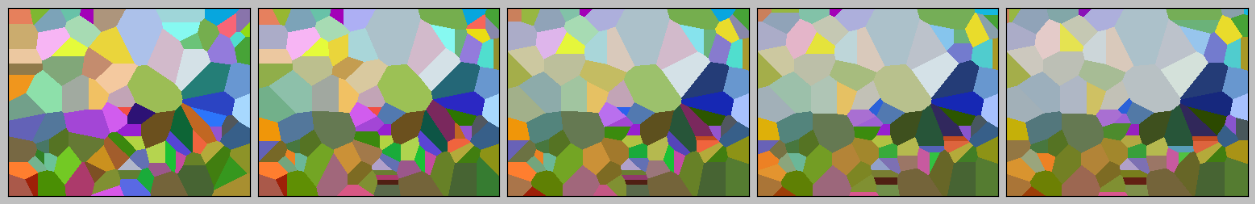

In [10]:
show_progress_over_time((0, 100, 'UNIFORM', 100, "RANDOM", 500), grid=(1,5))

/tmp/ipykernel_42709/2762498027.py:5: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.lineplot(data=df, x='num-generations', y='best-fitness', hue='crossover-method', errorbar=None, palette=custom_palette, style='crossover-method', markers=True, dashes=False)


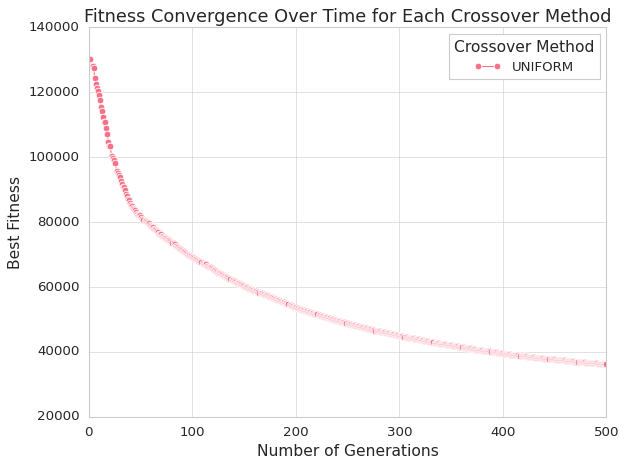

In [11]:
sns.set_style("whitegrid")

custom_palette = sns.color_palette("husl", 3)

sns.lineplot(data=df, x='num-generations', y='best-fitness', hue='crossover-method', errorbar=None, palette=custom_palette, style='crossover-method', markers=True, dashes=False)

plt.title('Fitness Convergence Over Time for Each Crossover Method', fontsize=16)
plt.xlabel('Number of Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Crossover Method', title_fontsize='14', fontsize='12', loc='best')
plt.tight_layout()
plt.show()